In [1]:
import sys
import os
from typing import List
from graphviz import Digraph

# Get the absolute path of the root directory
# root_directory = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

# Add the root directory to the Python module search path
# sys.path.append(root_directory)

root_directory = "/home/dejang/Workspace ML/PRML/prml-project/micrograd-transformers"
sys.path.append(root_directory)

from micrograd.engine import Value
from micrograd.nn import Linear, CrossEntropyLoss, Sigmoid, BinaryCrossEntropyLoss
from micrograd.optimizers import SGD

from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

In [2]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, params: List[Value], format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f %s }" % (n.data, n.grad, "| param" if n in params else ""), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [3]:
def create_dataset():
    # Load the Iris dataset
    iris = load_iris()

    # Extract the features (X) and target labels (y)
    X = iris.data
    y = iris.target.reshape(-1, 1)  # Reshape to column vector

    # Convert the class labels to one-hot encodings
    encoder = OneHotEncoder()
    y_one_hot = encoder.fit_transform(y).toarray()

    # Print the first 5 samples
    print("X:", X[:5])
    print("y (one-hot):", y_one_hot[:5])

    return X, y_one_hot



def train_linear(x: List[List[Value]], y: List[Value], num_classes: int,
                 in_neurons: int, out_neurons: int, nonlin=False, use_bias=True, 
                 epochs: int = 10):
    model = Linear(in_neurons, out_neurons, nonlin=nonlin ,use_bias=use_bias)    
    criterion = CrossEntropyLoss(num_classes)
    optimizer = SGD()

    draw = []
    print(f"Number of training parameters: {len(model.parameters())}")
    for i, (x_, y_) in enumerate(zip(x, y)):
        # if i > 0 : break
        pred = model(x_)
        # print(pred)
        # print(y_)
        loss = criterion(pred, y_)
        print(f"Loss: {loss.data:.4f}")

        # backward
        loss.backward()
        draw.append(draw_dot(loss, model.parameters()))
        print(f"Number of training parameters: {len(model.parameters())}")
        print(model.parameters())
        optimizer.step(model.parameters())

        # zero gradients
        model.zero_grad()
        # model.destroy_intermediate_values(all_values)
        loss.destroy_graph(model.parameters())

    return draw


In [4]:
X, y = create_dataset()
# Convert the dataset to micrograd values
train_data = []
train_labels = []
for x in X:
    temp = []
    for val in x:
        temp.append(Value(val))
    train_data.append(temp)
X = train_data
for label in y:
    temp = []
    for val in label:
        temp.append(Value(val))
    train_labels.append(temp)
y = train_labels

# Train a linear model
draw = train_linear(X, y, 3, in_neurons=4, out_neurons=3, nonlin=True, epochs=5)

X: [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
y (one-hot): [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Number of training parameters: 15
Loss: 0.0000
70
Number of training parameters: 15
[Value(data=0.978470121625119, grad=-1.700000017), Value(data=0.12216624223154815, grad=-1.1666666783333335), Value(data=0.6358813679244517, grad=-0.46666667133333334), Value(data=0.08077929100572168, grad=-0.06666666733333335), Value(data=0, grad=-0.3333333366666667), Value(data=-0.7692394603171229, grad=0.0), Value(data=-0.9810657062144839, grad=0.0), Value(data=0.25168323130042314, grad=0.0), Value(data=0.0797232052725445, grad=0.0), Value(data=0, grad=0.0), Value(data=0.2044985843987157, grad=0.0), Value(data=0.7675412175024887, grad=0.0), Value(data=-0.38472654552387087, grad=0.0), Value(data=0.9578547423698842, grad=0.0), Value(data=0, grad=0.0)]
Loss: 0.0000
70
Number of training parameters: 15
[Value(data=0.980170121642119, g

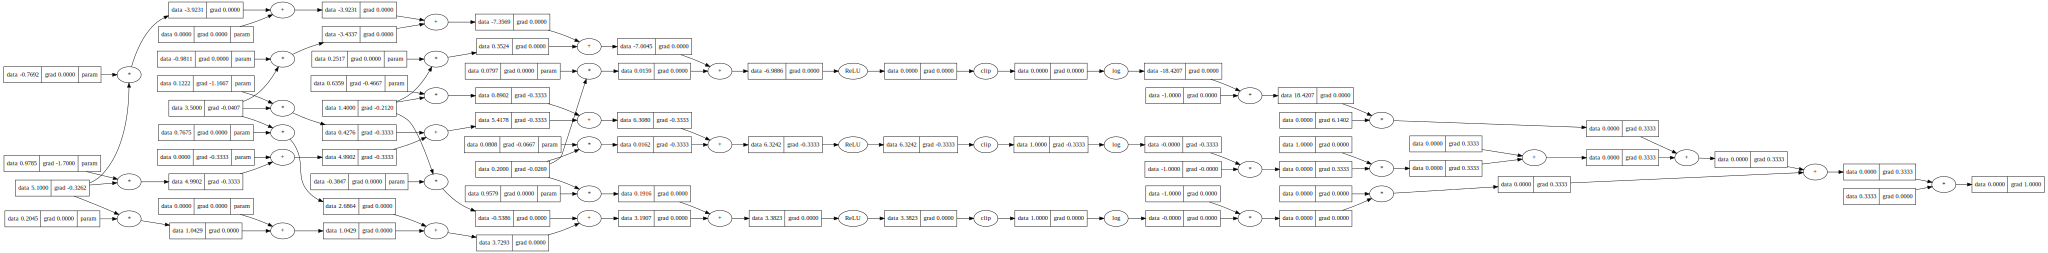

In [5]:
draw[0]

In [6]:
def calculate_mean_loss(loss_history: List[Value], epoch: int) -> float:
    key = f"Epoch {epoch}"
    losses = loss_history[key]
    return sum(losses) / len(losses)

def calculate_accuracy(result_history: List[Value], epoch: int) -> float:
    key = f"Epoch {epoch}"
    results = result_history[key]
    correct = 0
    for result in results:
        pred = result[0]
        y = result[1]
        if pred > 0.5 and y == 1:
            correct += 1
        elif pred < 0.5 and y == 0:
            correct += 1
    return correct / len(results)

def create_dataset():
    # Load the Iris dataset
    iris = load_iris()

    # Extract the features (X) and target labels (y)
    X = iris.data
    y = iris.target

    # Shuffle the dataset
    X, y = shuffle(X, y, random_state=42)

    # Select two out of three classes
    class_1_index = 0  # Index of the first class to include
    class_2_index = 2  # Index of the second class to include

    selected_indices = (y == class_1_index) | (y == class_2_index)
    X_selected = X[selected_indices]
    y_selected = y[selected_indices]

    # Convert the labels to binary values (0 or 1)
    label_encoder = LabelEncoder()
    y_binary = label_encoder.fit_transform(y_selected)

    # Print the first 5 samples
    print("X (selected):", X_selected[:5])
    print("y (binary):", y_binary[:5])

    return X, y_binary

def train_linear(x: List[List[Value]], y: List[Value],
                 in_neurons: int, nonlin=False, use_bias=True, 
                 epochs: int = 10):
    model = Linear(in_neurons, 1, nonlin=nonlin ,use_bias=use_bias)
    activation = Sigmoid()
    print(f"Number of training parameters: {len(model.parameters())}")
        
    criterion = BinaryCrossEntropyLoss()
    optimizer = SGD()
    loss_history = {}
    result_history = {}

    # for epoch in range(epochs):
        # loss_history[f"Epoch {epoch + 1}"] = []
        # result_history[f"Epoch {epoch + 1}"] = []
    epoch = 0
    draw = None
    for i, (x_, y_) in enumerate(zip(x, y)):
        if i > 0 : break
        pred = model(x_)
        print(f"Linear: {pred[0].data}")
        pred = activation(pred)
        print(f"Sigmoid: {pred[0].data}")
        loss = criterion(pred, y_)
        # loss_history[f"Epoch {epoch + 1}"].append(loss.data)
        # result_history[f"Epoch {epoch + 1}"].append([pred[0].data, y_[0].data])
        # print(f"Loss: {loss.data:.4f}")

        # backward
        loss.backward()
        draw = draw_dot(loss, model.parameters())
        optimizer.step(model.parameters())

        # zero gradients
        model.zero_grad()
        loss.destroy_graph(model.parameters())

        # print(f"Epoch: {epoch + 1}/{epochs} | Loss: {calculate_mean_loss(loss_history, epoch + 1):.4f}" + 
        #      f"| Accuracy: {calculate_accuracy(result_history, epoch + 1):.4f}")
        # print("--------------------------------------------------")
    return draw


In [7]:
if __name__ == "__main__":
    # Create a dataset for classification
    X, y = create_dataset()

    # Convert the dataset to micrograd values
    train_data = []
    train_labels = []
    for x in X:
        temp = []
        for val in x:
            temp.append(Value(val))
        train_data.append(temp)
    train_labels = []
    for label in y:
        train_labels.append([Value(label)])
    print(f"Number of instances {len(train_data)}")
    # Train a linear model
    draw = train_linear(train_data, train_labels, in_neurons=4, nonlin=False, epochs=20)

X (selected): [[5.7 3.8 1.7 0.3]
 [7.7 2.6 6.9 2.3]
 [5.4 3.4 1.5 0.4]
 [6.9 3.1 5.1 2.3]
 [6.5 3.2 5.1 2. ]]
y (binary): [0 1 0 1 1]
Number of instances 150
Number of training parameters: 5
Linear: 0.817982195919293
Sigmoid: 0.6938078485137977


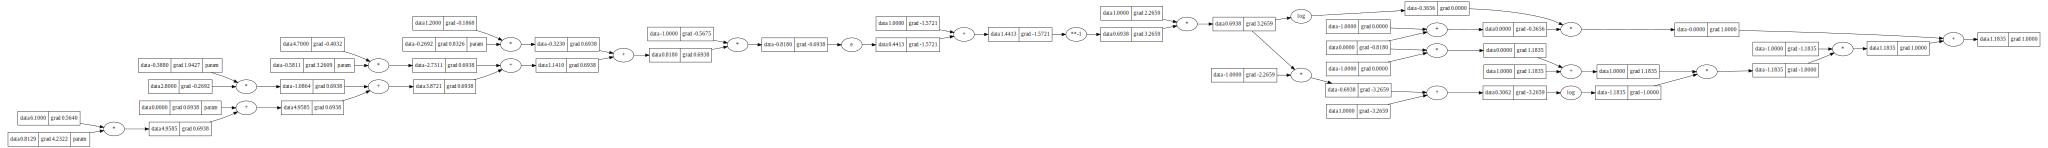

In [8]:
draw